In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression

file_path = r"C:\Users\ofek3\OneDrive\Desktop\Idea_1973_Code\Sourse_Idea\data\nberces5818v1_n2012.csv"
df = pd.read_csv(file_path)

In [164]:
#  --- תא הכנת נתונים ריאליים (VADD) ---
# 1. יצירת משתנים ריאליים - ניכוי אינפלציה
# חילוק במדד המחירים של אנרגיה - מייצג את כמות האנרגיה הפיזית שנצרכה
df['real_energy'] = df['energy'] / df['pien']

# שימוש ב-VADD (ערך מוסף) וניכויו באמצעות PISHIP (מדד מחירי התפוקה)
# רציונל: VADD מייצג את הצמיחה האמיתית של התעשייה ללא רעשי חומרי הגלם
df['real_vadd'] = df['vadd'] / df['piship']

# 2. חישוב עצימות האנרגיה ביחס לערך המוסף
# מדד זה בודק כמה יחידות אנרגיה נדרשו כדי לייצר יחידה אחת של ערך מוסף
df['real_energy_intensity'] = df['real_energy'] / df['real_vadd']

print(f".גודל הטבלה הסופי: {df.shape} מעודכן עם VADD")
df[['year', 'naics', 'vadd', 'real_energy_intensity', 'real_vadd']].head()

.גודל הטבלה הסופי: (22204, 27) מעודכן עם VADD


,year,naics,vadd,real_energy_intensity,real_vadd
0,1958,311111,266.9,0.080038,753.954798
1,1959,311111,268.7,0.085969,778.840582
2,1960,311111,269.9,0.072514,985.036536
3,1961,311111,287.8,0.075400,1054.212447
4,1962,311111,294.5,0.079831,1063.176857


In [165]:
# בדיקת איכות הנתונים: ספירת ערכים חסרים
missing_count = df['real_energy_intensity'].isnull().sum()
missing_count

np.int64(117)

In [166]:
# 1. הסרת שורות שבהן חסר מידע 
df_clean = df.dropna(subset=['real_energy_intensity', 'tfp5']).copy()

# 2. סינון השנים המדויקות למחקר: לפני המשבר, המשבר, וההתאוששות (1958-2018)
df_final = df_clean[(df_clean['year'] >= 1958) & (df_clean['year'] <= 2018)]

# בדיקה כמה נתונים נשארו לנו בסט הסופי
df_final.shape

(21359, 27)

In [167]:
# --- סיווג וסטטיסטיקה תיאורית ---
# 1. סיווג תעשיות לפי עצימות אנרגיה (שלישים - Terciles) על בסיס הנתונים של 1958-1972
# אנו מגדירים את הסטטוס של כל תעשייה ב-4 השנים לפני פרוץ המשבר

# לשנות שהתקופה שלפני המשבר היא מ1958
df_1958_1972 = df_final[(df_final['year'] <= 1972) & (df_final['year'] >= 1958)].copy()
mean_energy = df_1958_1972.groupby('naics')['real_energy_intensity'].mean()
energy_thresholds = mean_energy.quantile([0.33, 0.66])

def classify_energy(val):
    if val <= energy_thresholds[0.33]: return 'Low Energy'
    elif val <= energy_thresholds[0.66]: return 'Medium Energy'
    else: return 'High Energy'

# יצירת המיפוי והחלה על כל הטבלה
energy_map = mean_energy.apply(classify_energy)
df_final['group_name'] = df_final['naics'].map(energy_map)

# יצירת משתני עזר לרגרסיה (0 ו-1)
df_final['is_high_energy'] = (df_final['group_name'] == 'High Energy').astype(int)
df_final['post_1973'] = (df_final['year'] >= 1973).astype(int)
df_final['is_low_energy'] = (df_final['group_name'] == 'Low Energy').astype(int)

# 2. סיווג תעשיות לפי גודל (מספר עובדים ממוצע לפני המשבר)
industry_size = df_final[df_final['year'] < 1973].groupby('naics')['emp'].mean()
size_thresholds = industry_size.quantile([0.33, 0.66])

def classify_size(emp_avg):
    if emp_avg <= size_thresholds[0.33]: return 'Small Industry'
    elif emp_avg <= size_thresholds[0.66]: return 'Medium Industry'
    else: return 'Large Industry'

# החלת סיווג הגודל
# industry_size_cat - לשנות שלא יהיה בקטגוריות, אלא רציף
df_final['industry_size_cat'] = df_final['naics'].map(industry_size.apply(classify_size))

# 3. יצירת טבלת סטטיסטיקה תיאורית
# מחשבים ממוצע וסטיית תקן עבור המשתנים הבסיסיים
desc_stats = df_final.groupby('group_name')[['tfp5', 'real_energy_intensity', 'emp']].agg(['mean', 'std']).round(3)

print("--- SUMMARY STATISTICS BY ENERGY GROUP (TERCILES) ---")
display(desc_stats) 

# 4. בדיקת התפלגות התעשיות
print("\n--- INDUSTRY SIZE DISTRIBUTION ---")
print(df_final.drop_duplicates('naics')['industry_size_cat'].value_counts())

print("\n--- ENERGY GROUP DISTRIBUTION ---")
print(df_final.drop_duplicates('naics')['group_name'].value_counts())

--- SUMMARY STATISTICS BY ENERGY GROUP (TERCILES) ---


tfp5        real_energy_intensity            emp        
                mean    std                  mean    std    mean     std
group_name                                                              
High Energy    0.852  0.261                 0.344  3.501  39.990  56.246
Low Energy     1.048  0.241                 0.018  0.009  51.013  65.309
Medium Energy  0.953  0.213                 0.030  0.013  39.999  41.568


--- INDUSTRY SIZE DISTRIBUTION ---
industry_size_cat
Large Industry     123
Small Industry     119
Medium Industry    119
Name: count, dtype: int64

--- ENERGY GROUP DISTRIBUTION ---
group_name
High Energy      123
Low Energy       119
Medium Energy    119
Name: count, dtype: int64


In [168]:
# --- יצירת טבלאות המציגות את סיווג התעשיות ---

# 1. יצירת רשימה ייחודית של תעשיות והקבוצה שלהן
# אנו לוקחים רק שורה אחת לכל תעשייה (למשל משנת 1972) כדי לא לקבל כפילויות
industry_list = df_final[df_final['year'] == 1972][['naics', 'group_name', 'real_energy_intensity']].copy()
industry_list = industry_list.sort_values(['group_name', 'real_energy_intensity'], ascending=[True, False])

# 2. יצירת "טבלת דוגמאות" (Sample Table) להצגה בעבודה
# הפונקציה לוקחת את 5 התעשיות עם עצימות האנרגיה הגבוהה ביותר בכל קבוצה (הכי "מייצגות")
def get_top_examples(group_df):
    return group_df.head(5)['naics'].tolist()

sample_table = industry_list.groupby('group_name').apply(get_top_examples).reset_index()
sample_table.columns = ['Energy Group', 'Top 5 Representative Industries (NAICS Codes)']

print("--- טבלת דוגמאות: התעשיות הקיצוניות ביותר בכל קבוצה ---")
display(sample_table)

# 3. ייצוא הרשימה המלאה לאקסל (עבור הנספח בעבודה)
# זה ייצור קובץ שתוכל לפתוח, להוסיף לו ידנית את שמות התעשיות (טקסט), ולהדביק בנספח
industry_list.to_csv('industry_classification_list.csv', index=False)
print("\nהרשימה המלאה נשמרה לקובץ: 'industry_classification_list.csv'")

# 4. בדיקת שפיות (Sanity Check) - בחינת הקיצון
print("\n--- הוכחת תוקף (Face Validity) ---")
print("התעשייה עם עצימות האנרגיה הכי גבוהה (High Energy):")
top_industry = industry_list.iloc[0]
print(f"NAICS: {top_industry['naics']}, Intensity: {top_industry['real_energy_intensity']:.4f}")

print("\nהתעשייה עם עצימות האנרגיה הכי נמוכה (Low Energy):")
bottom_industry = industry_list.iloc[-1]
print(f"NAICS: {bottom_industry['naics']}, Intensity: {bottom_industry['real_energy_intensity']:.4f}")

--- טבלת דוגמאות: התעשיות הקיצוניות ביותר בכל קבוצה ---


C:\Users\ofek3\AppData\Local\Temp\ipykernel_39548\373644418.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_table = industry_list.groupby('group_name').apply(get_top_examples).reset_index()


,Energy Group,Top 5 Representative Industries (NAICS Codes)
0,High Energy,"[334111, 334413, 334112, 334118, 311213]"
1,Low Energy,"[336330, 336340, 336350, 336390, 316992]"
2,Medium Energy,"[332812, 331420, 311612, 331222, 311423]"



הרשימה המלאה נשמרה לקובץ: 'industry_classification_list.csv'

--- הוכחת תוקף (Face Validity) ---
התעשייה עם עצימות האנרגיה הכי גבוהה (High Energy):
NAICS: 334111, Intensity: 64.4488

התעשייה עם עצימות האנרגיה הכי נמוכה (Low Energy):
NAICS: 325413, Intensity: 0.0186


In [169]:
# --- ניתוח השוואתי בין תקופות (Structural Break Analysis) ---

# חישוב משתני צמיחה לגרפים
df_final = df_final.sort_values(['naics', 'year'])
df_final['vadd_growth'] = df_final.groupby('naics')['real_vadd'].pct_change() * 100

# הגדרת התקופות
# אנו מגדירים את 1973 כשנת הגבול.
# Pre-Crisis: עד וכולל 1973 
# Post-Crisis: מ-1974 והלאה 
df_final['period'] = np.where(df_final['year'] <= 1973, 'Pre-Crisis (1958-1973)', 'Post-Crisis (1974-2018)')

# בחירת המשתנים להשוואה
# פריון (TFP), עצימות אנרגיה (Efficiency), וצמיחה (Growth)
cols_to_analyze = ['tfp5', 'real_energy_intensity', 'vadd_growth']

# חישוב סטטיסטיקה תיאורית (ממוצע וסטיית תקן) לכל תקופה ולכל קבוצה
period_stats = df_final.groupby(['group_name', 'period'])[cols_to_analyze].agg(['mean', 'std'])

# חישוב "השינוי המבני" 
# אנו רוצים לראות בכמה הממוצע השתנה בין התקופות
# לשם כך נפרק את הטבלה ונחסר את ה-Pre מה-Post
pre_means = df_final[df_final['period'] == 'Pre-Crisis (1958-1973)'].groupby('group_name')[cols_to_analyze].mean()
post_means = df_final[df_final['period'] == 'Post-Crisis (1974-2018)'].groupby('group_name')[cols_to_analyze].mean()

change_table = post_means - pre_means

print("=" * 80)
print("STRUCTURAL BREAK TABLE: PRE vs. POST CRISIS")
print("=" * 80)
print("הסבר: הטבלה מציגה את הממוצע (mean) וסטיית התקן (std) בכל תקופה.")
display(period_stats.round(3))

print("\n" + "=" * 80)
print("THE SHIFT: CHANGE IN AVERAGES (POST - PRE)")
print("=" * 80)
print("הסבר: הטבלה מציגה את הפער שנוצר. ערך שלילי ב-Energy Intensity הוא טוב (התייעלות).")
display(change_table.round(4))

STRUCTURAL BREAK TABLE: PRE vs. POST CRISIS
הסבר: הטבלה מציגה את הממוצע (mean) וסטיית התקן (std) בכל תקופה.


tfp5        real_energy_intensity  \
                                        mean    std                  mean   
group_name    period                                                        
High Energy   Post-Crisis (1974-2018)  0.896  0.235                 0.157   
              Pre-Crisis (1958-1973)   0.732  0.289                 0.845   
Low Energy    Post-Crisis (1974-2018)  1.031  0.222                 0.019   
              Pre-Crisis (1958-1973)   1.091  0.281                 0.016   
Medium Energy Post-Crisis (1974-2018)  0.982  0.179                 0.029   
              Pre-Crisis (1958-1973)   0.873  0.269                 0.032   

                                             vadd_growth          
                                         std        mean     std  
group_name    period                                              
High Energy   Post-Crisis (1974-2018)  0.892       2.812  17.221  
              Pre-Crisis (1958-1973)   6.538       6.613  11.856  
Low Energy    Post-Crisis (1974-2018)  0.010       1.356  14.451  
              Pre-Crisis (1958-1973)   0.006       5.527  11.587  
Medium Energy Post-Crisis (1974-2018)  0.014       1.894  13.060  
              Pre-Crisis (1958-1973)   0.009       6.638  13.166


THE SHIFT: CHANGE IN AVERAGES (POST - PRE)
הסבר: הטבלה מציגה את הפער שנוצר. ערך שלילי ב-Energy Intensity הוא טוב (התייעלות).


,tfp5,real_energy_intensity,vadd_growth
group_name,,,
High Energy,0.1645,-0.6877,-3.8007
Low Energy,-0.0597,0.0031,-4.1711
Medium Energy,0.1092,-0.0027,-4.7438


In [170]:
# --- הכנת נתונים והגדרת עיצוב אקדמי ---

# הגדרת עיצוב גרפים (Global Style Settings)

# ערכת נושא נקייה
plt.style.use('seaborn-v0_8-whitegrid')

# הגדרות ידניות
params = {
    # גופנים (Fonts)
    'font.family': 'sans-serif', 
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    
    'axes.labelsize': 14,          # גודל טקסט ציר ה-X וה-Y
    'axes.titlesize': 16,          # גודל הכותרת הראשית
    'xtick.labelsize': 12,         # גודל המספרים על הציר
    'ytick.labelsize': 12,
    'legend.fontsize': 12,         # גודל הטקסט במקרא
    
    # חדות וקווים
    'lines.linewidth': 2.5,        # עובי הקווים בגרף 
    'figure.dpi': 120,             # רזולוציה גבוהה 
    'axes.grid': True,             # הצגת רשת
    'grid.alpha': 0.3              # רשת שקופה
}

# החלת ההגדרות על כל הגרפים במחברת
plt.rcParams.update(params)

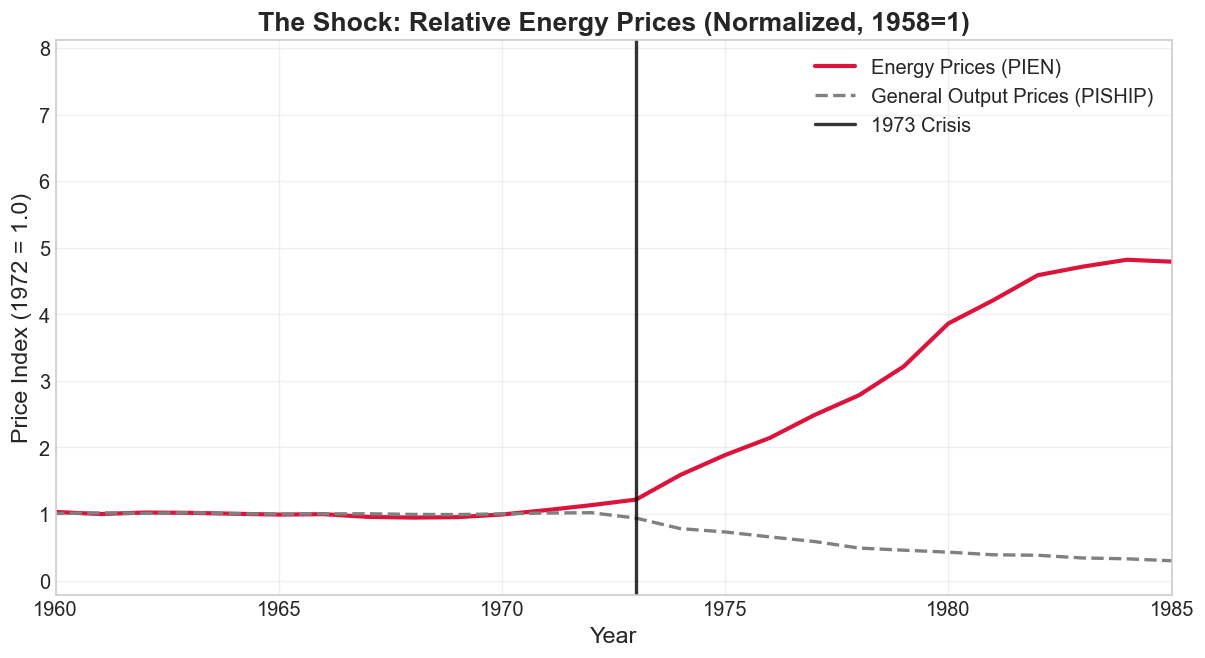

In [171]:
# --- גרף ההלם (מחירי אנרגיה מול מחירי תפוקה) ---

plt.figure(figsize=(12, 6))

# חישוב ממוצע שנתי של המדדים
price_trends = df_final.groupby('year')[['pien', 'piship']].mean()

# נרמול המדדים כך ששנת 1972 תהיה נקודת הייחוס (=1.0)
base_year_val = price_trends.loc[1958]
normalized_prices = price_trends / base_year_val

# ציור הגרפים
plt.plot(normalized_prices.index, normalized_prices['pien'], label='Energy Prices (PIEN)', color='crimson', linewidth=2.5)
plt.plot(normalized_prices.index, normalized_prices['piship'], label='General Output Prices (PISHIP)', color='grey', linestyle='--', linewidth=2)

# עיצוב
plt.axvline(x=1973, color='black', linestyle='-', alpha=0.8, label='1973 Crisis', linewidth = 2)
plt.title('The Shock: Relative Energy Prices (Normalized, 1958=1)', fontweight='bold')
plt.ylabel('Price Index (1972 = 1.0)')
plt.xlabel('Year')
plt.legend()
plt.xlim(1960, 1985) # התמקדות בשנים הרלוונטיות

plt.show()
# הגרף הזה מראה שאחרי המשבר מחירי האנרגיה "התנתקו" משאר המחירים במשק ב 1973

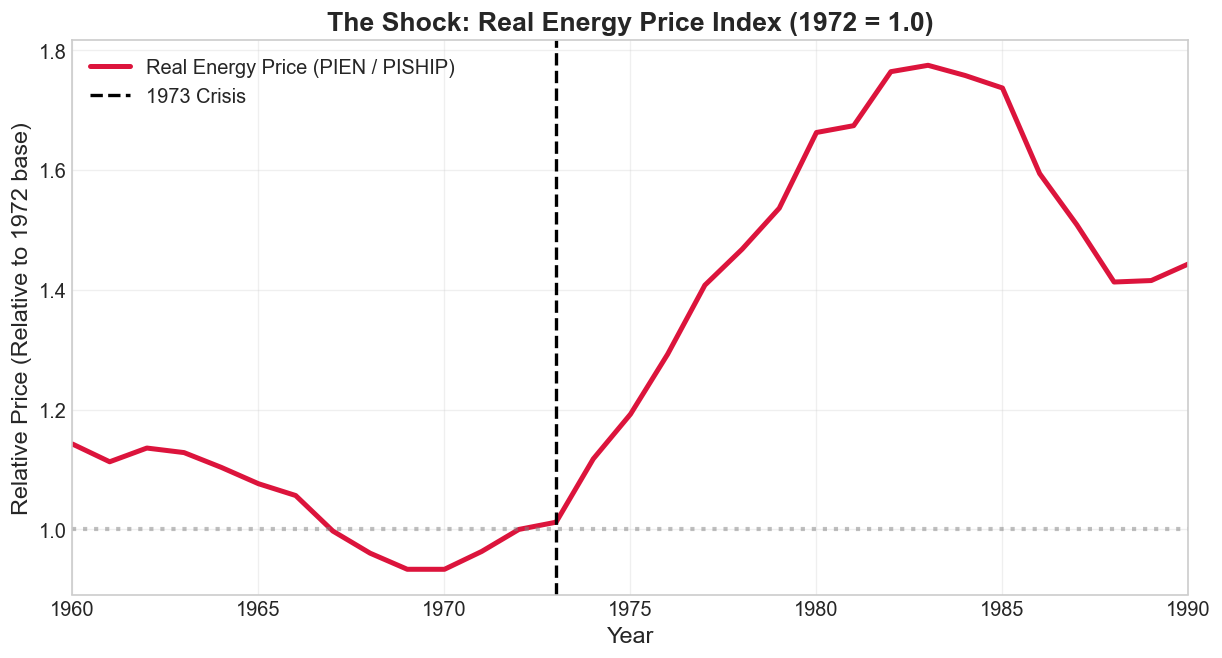

In [172]:
plt.figure(figsize=(12, 6))

# 1. חישוב המחיר היחסי האמיתי (Real Energy Price)
# אנו מחלקים את מדד האנרגיה במדד התפוקה הכללי
# המשמעות: האם האנרגיה התייקרה *יותר* משאר הדברים במשק?
df_final['relative_price'] = df_final['pien'] / df_final['piship']

# 2. חישוב הממוצע השנתי של המחיר היחסי
relative_trend = df_final.groupby('year')['relative_price'].mean()

# 3. נרמול לשנת 1972 (כדי שנוכל להגיד "פי כמה זה גדל ביחס ללפני המשבר")
base_year_val = relative_trend.loc[1972]
normalized_relative = relative_trend / base_year_val

# ציור הגרף (קו אחד ברור)
plt.plot(normalized_relative.index, normalized_relative.values, 
         color='crimson', linewidth=3, label='Real Energy Price (PIEN / PISHIP)')

# עיצוב
plt.axvline(x=1973, color='black', linestyle='--', linewidth=2, label='1973 Crisis')
plt.axhline(y=1, color='grey', linestyle=':', alpha=0.5) # קו ייחוס

plt.title('The Shock: Real Energy Price Index (1972 = 1.0)', fontweight='bold')
plt.ylabel('Relative Price (Relative to 1972 base)')
plt.xlabel('Year')
plt.legend()
plt.xlim(1960, 1990) 

plt.show()

# הסבר:
# כעת הגרף מראה את ה"הלם" בצורה נקייה.
# אנו רואים שעד 1973 המחיר היחסי היה יציב (סביב 1.0),
# ואז הוא מזנק פי 2-3. זהו השינוי שדחף את החברות להתייעל.

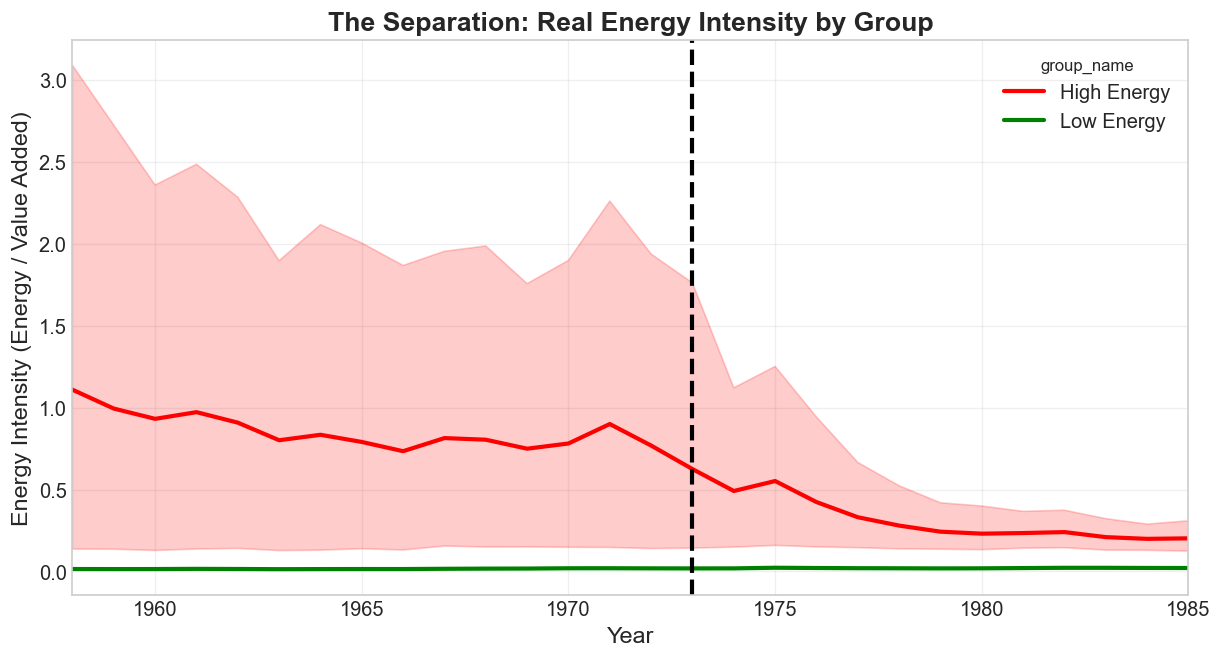

In [173]:
# --- גרף ההפרדה (עצימות אנרגיה לאורך זמן) ---

plt.figure(figsize=(12, 6))

# שימוש ב-Seaborn שמוסיף אוטומטית רווח בר-סמך (הצללה)
# אנו מסננים רק את קבוצות הקיצון כדי שהגרף יהיה ברור
subset = df_final[df_final['group_name'].isin(['High Energy', 'Low Energy'])]

sns.lineplot(data=subset, x='year', y='real_energy_intensity', hue='group_name', 
             palette={'High Energy': 'red', 'Low Energy': 'green'}, linewidth=2.5)

# עיצוב
plt.axvline(x=1973, color='black', linestyle='--', label='1973 Crisis')
plt.title('The Separation: Real Energy Intensity by Group', fontweight='bold')
plt.ylabel('Energy Intensity (Energy / Value Added)')
plt.xlabel('Year')
plt.xlim(1958, 1985) # התמקדות בתקופת המחקר המרכזית

plt.show()

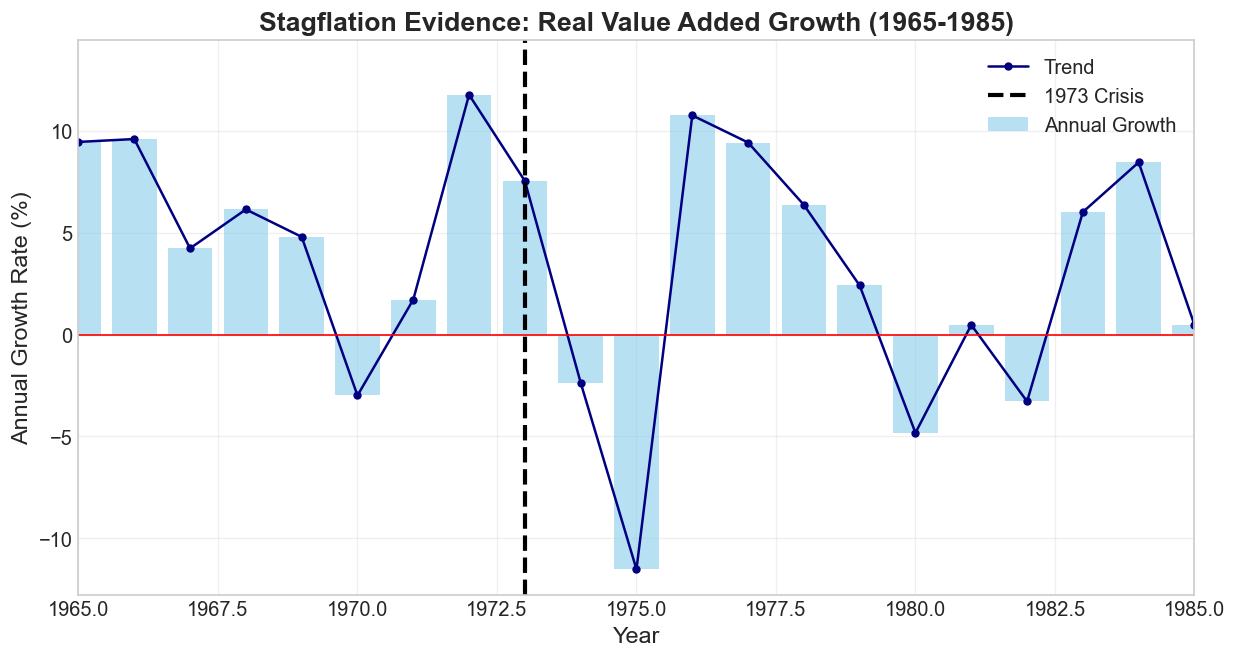

In [174]:
# --- גרף הסטגפלציה (צמיחת VADD) ---

plt.figure(figsize=(12, 6))

# חישוב צמיחה ממוצעת לכלל התעשייה
avg_growth = df_final.groupby('year')['vadd_growth'].mean()

# יצירת גרף עמודות וקו משולב
plt.bar(avg_growth.index, avg_growth.values, color='skyblue', alpha=0.6, label='Annual Growth')
plt.plot(avg_growth.index, avg_growth.values, color='navy', marker='o', markersize=4, linewidth=1.5, label='Trend')

# קו ה-0 (מיתון מתחת לקו זה)
plt.axhline(y=0, color='red', linestyle='-', linewidth=1)
plt.axvline(x=1973, color='black', linestyle='--', label='1973 Crisis')

# עיצוב
plt.title('Stagflation Evidence: Real Value Added Growth (1965-1985)', fontweight='bold')
plt.ylabel('Annual Growth Rate (%)')
plt.xlabel('Year')
plt.xlim(1965, 1985) # זום-אין על תקופת המשבר
plt.legend()

plt.show()

# לשקול להוסיף גרף זהה לאנרגיות גבוהה ונמוכה אחרי ה matching

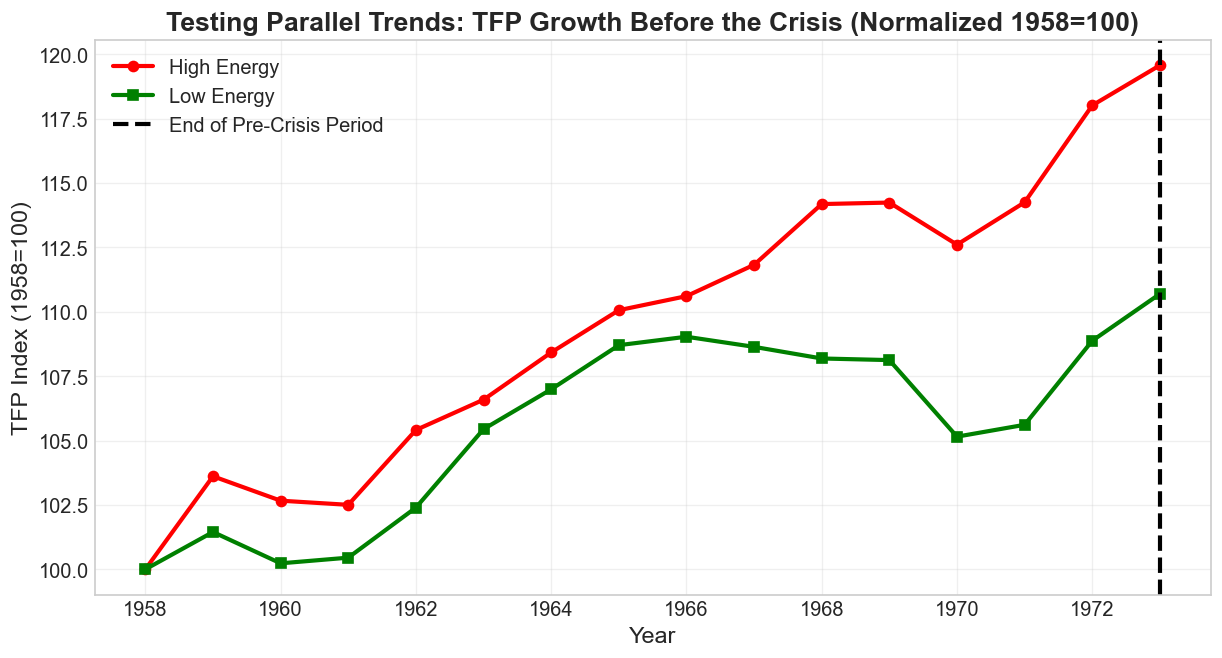

In [175]:
# ---  גרף מגמות מקבילות (TFP לפני המשבר) ---

plt.figure(figsize=(12, 6))

# סינון נתונים עד 1973 וקבוצות קיצון
pre_crisis = df_final[(df_final['year'] <= 1973) & (df_final['group_name'].isin(['High Energy', 'Low Energy']))]

# חישוב ממוצע שנתי לכל קבוצה
tfp_trends = pre_crisis.groupby(['year', 'group_name'])['tfp5'].mean().unstack()

# נרמול לשנת הבסיס (1958=100) כדי להשוות שיפועים (קצב שינוי) ולא רמות אבסולוטיות
tfp_normalized = tfp_trends / tfp_trends.loc[1958] * 100

# ציור
plt.plot(tfp_normalized.index, tfp_normalized['High Energy'], label='High Energy', color='red', marker='o')
plt.plot(tfp_normalized.index, tfp_normalized['Low Energy'], label='Low Energy', color='green', marker='s')

# עיצוב
plt.axvline(x=1973, color='black', linestyle='--', label='End of Pre-Crisis Period')
plt.title('Testing Parallel Trends: TFP Growth Before the Crisis (Normalized 1958=100)', fontweight='bold')
plt.ylabel('TFP Index (1958=100)')
plt.xlabel('Year')
plt.legend()

plt.show()

C:\Users\ofek3\AppData\Local\Temp\ipykernel_39548\2789330105.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final[df_final['year']==1972], x='group_name', y='real_vadd',
C:\Users\ofek3\AppData\Local\Temp\ipykernel_39548\2789330105.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final[df_final['year']==1972], x='group_name', y='emp',


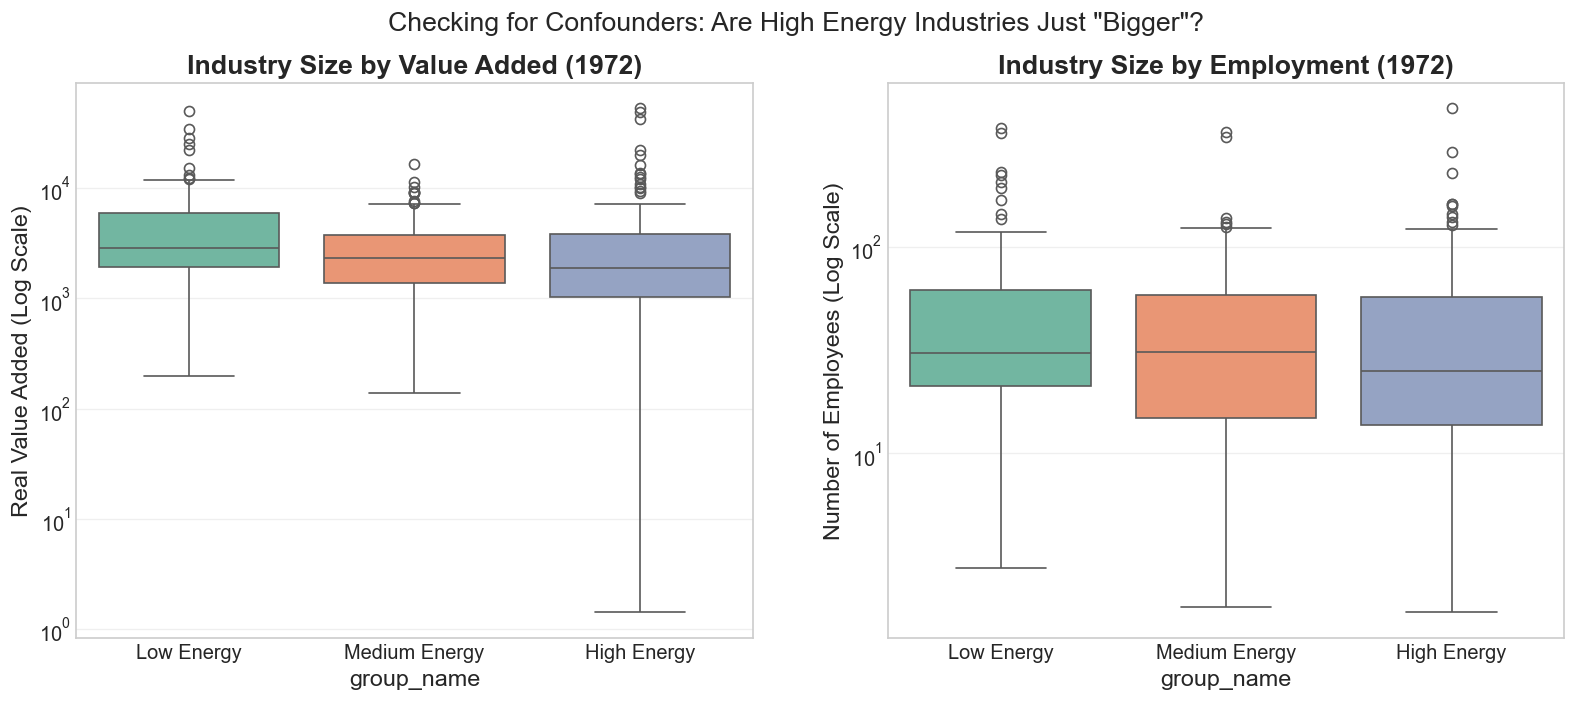

In [176]:
# --- השוואת מאפייני תעשייה (בדיקת משתנים מתערבים) ---

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# גרף שמאלי: גודל לפי ערך מוסף (VADD)
sns.boxplot(data=df_final[df_final['year']==1972], x='group_name', y='real_vadd', 
            order=['Low Energy', 'Medium Energy', 'High Energy'], ax=axes[0], palette='Set2')
axes[0].set_yscale('log') # סקאלה לוגריתמית בגלל פערי גודל עצומים
axes[0].set_title('Industry Size by Value Added (1972)', fontweight='bold')
axes[0].set_ylabel('Real Value Added (Log Scale)')

# גרף ימני: גודל לפי מספר עובדים (EMP)
sns.boxplot(data=df_final[df_final['year']==1972], x='group_name', y='emp', 
            order=['Low Energy', 'Medium Energy', 'High Energy'], ax=axes[1], palette='Set2')
axes[1].set_yscale('log')
axes[1].set_title('Industry Size by Employment (1972)', fontweight='bold')
axes[1].set_ylabel('Number of Employees (Log Scale)')

plt.suptitle('Checking for Confounders: Are High Energy Industries Just "Bigger"?', fontsize=16)
plt.show()

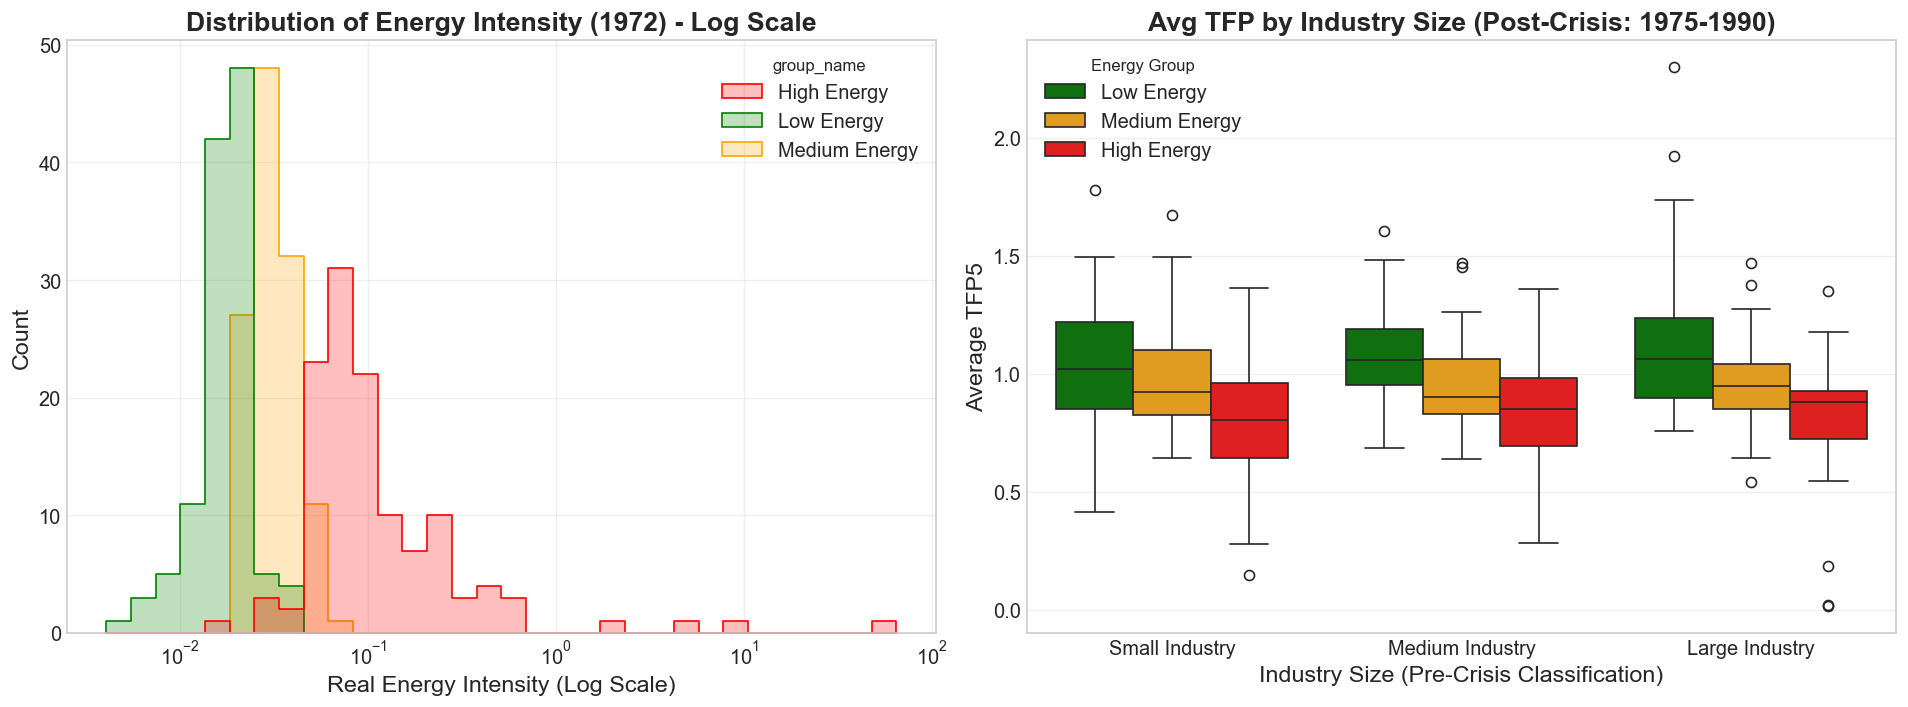

In [177]:
# --- בדיקת תוקף ומשתנים מתערבים ---

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- גרף שמאל: התפלגות עצימות האנרגיה - לוגריתמי---
sns.histplot(
    data=df_final[df_final['year'] == 1972], 
    x='real_energy_intensity', 
    hue='group_name', 
    element="step", 
    log_scale=True,  
    ax=axes[0],
    palette={'High Energy': 'red', 'Medium Energy': 'orange', 'Low Energy': 'green'}
)
axes[0].set_title('Distribution of Energy Intensity (1972) - Log Scale', fontweight='bold')
axes[0].set_xlabel('Real Energy Intensity (Log Scale)')

# --- גרף ימין: פריון לפי גודל וקבוצת אנרגיה (ממוצע פוסט-משבר) ---
post_crisis_avg = df_final[
    (df_final['year'] >= 1975) & (df_final['year'] <= 1990)
].groupby(['naics', 'group_name', 'industry_size_cat'])['tfp5'].mean().reset_index()

# סידור הקטגוריות שיהיה הגיוני בעין (קטן -> בינוני -> גדול)
size_order = ['Small Industry', 'Medium Industry', 'Large Industry']

sns.boxplot(
    data=post_crisis_avg, 
    x='industry_size_cat', 
    y='tfp5', 
    hue='group_name', 
    order=size_order,
    hue_order=['Low Energy', 'Medium Energy', 'High Energy'], # סדר הגיוני במקרא
    palette={'High Energy': 'red', 'Medium Energy': 'orange', 'Low Energy': 'green'},
    ax=axes[1]
)

axes[1].set_title('Avg TFP by Industry Size (Post-Crisis: 1975-1990)', fontweight='bold')
axes[1].set_ylabel('Average TFP5')
axes[1].set_xlabel('Industry Size (Pre-Crisis Classification)')
axes[1].legend(title='Energy Group')

plt.tight_layout()
plt.show()

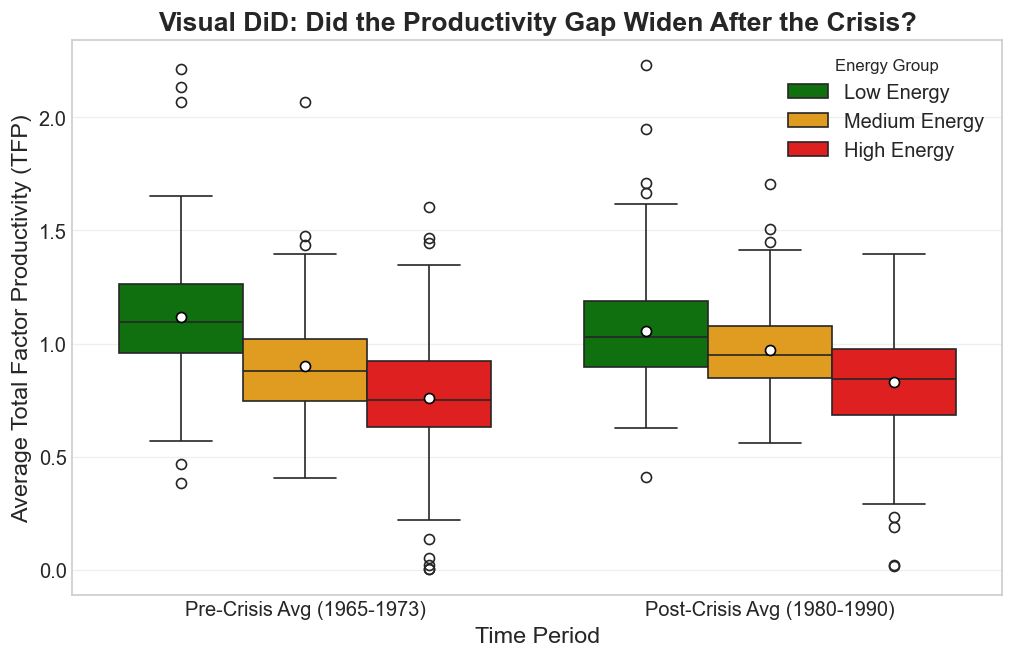

In [178]:
period_comparison = []

# תקופה 1: לפני המשבר (1965-1973)
pre_data = df_final[(df_final['year'] >= 1965) & (df_final['year'] <= 1973)].copy()
pre_means = pre_data.groupby(['naics', 'group_name'])['tfp5'].mean().reset_index()
pre_means['Period'] = 'Pre-Crisis Avg (1965-1973)'
period_comparison.append(pre_means)

# תקופה 2: אחרי המשבר (1980-1990)
post_data = df_final[(df_final['year'] >= 1980) & (df_final['year'] <= 1990)].copy()
post_means = post_data.groupby(['naics', 'group_name'])['tfp5'].mean().reset_index()
post_means['Period'] = 'Post-Crisis Avg (1980-1990)'
period_comparison.append(post_means)

# איחוד לטבלה אחת לצורך הציור
viz_data = pd.concat(period_comparison)

# 2. הציור: Boxplot שמשווה את ההתפלגויות
plt.figure(figsize=(10, 6))

# סדר הקבוצות בתרשים
hue_order = ['Low Energy', 'Medium Energy', 'High Energy']
palette = {'High Energy': 'red', 'Medium Energy': 'orange', 'Low Energy': 'green'}

sns.boxplot(
    data=viz_data, 
    x='Period', 
    y='tfp5', 
    hue='group_name',
    hue_order=hue_order,
    palette=palette,
    showmeans=True, # מוסיף נקודה שמראה את הממוצע המדויק
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"}
)

plt.title('Visual DiD: Did the Productivity Gap Widen After the Crisis?', fontweight='bold')
plt.ylabel('Average Total Factor Productivity (TFP)')
plt.xlabel('Time Period')
plt.legend(title='Energy Group')
plt.grid(True, axis='y', alpha=0.3)

plt.show()

# הסבר לגרף:
# אם ה"קופסה האדומה" עולה למעלה בתקופה השנייה יותר מהר מה"קופסה הירוקה",
# זה רמז חזק שהמשבר דחף את תעשיות האנרגיה להתייעלות יתרה.

# להציג בטבלה ולא בגרף

In [179]:
# --- תא: פונקציית Propensity Score Matching (כתיבה לקובץ לוג) ---

def perform_psm(df, treatment_col, covariates, base_period, mode='static', caliper=0.05, log_file="psm_log.txt"):
    """
    מבצעת שידוך וכותבת את המידע המפורט לקובץ טקסט כדי לשמור על המחברת נקייה.
    """
    
    # פתיחת הקובץ לכתיבה (מצב 'append' כדי לא למחוק מה שכתבנו בשלבים קודמים)
    # אנו פותחים וסוגרים בתוך הלולאה או בפונקציה הראשית כדי לשמור על פשטות
    
    def log_message(msg):
        with open(log_file, "a") as f:
            f.write(msg + "\n")

    def match_on_data(data_slice, year_label):
        # ניקוי שורות
        valid_data = data_slice.dropna(subset=covariates + [treatment_col])
        
        if valid_data.empty or valid_data[treatment_col].sum() == 0:
            return pd.DataFrame()

        # 1. חישוב Propensity Score
        logit = LogisticRegression(solver='liblinear')
        logit.fit(valid_data[covariates], valid_data[treatment_col])
        valid_data = valid_data.copy()
        valid_data['ps_score'] = logit.predict_proba(valid_data[covariates])[:, 1]
        
        # 2. הפרדה
        treated = valid_data[valid_data[treatment_col] == 1]
        control = valid_data[valid_data[treatment_col] == 0]
        
        if treated.empty or control.empty:
            return pd.DataFrame()

        # 3. מציאת השכן הקרוב ביותר
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control[['ps_score']])
        distances, indices = nbrs.kneighbors(treated[['ps_score']])
        
        # 4. סינון Caliper
        distances = distances.flatten()
        indices = indices.flatten()
        mask = distances <= caliper
        
        matched_treated = treated[mask]
        matched_control = control.iloc[indices[mask]]
        
        # --- לוג לקובץ ---
        dropped = len(treated) - len(matched_treated)
        kept = len(matched_treated)
        if dropped > 0:
            log_message(f"   [Year {year_label:<4}] Dropped: {dropped:<3} | Kept: {kept:<3} (Low Quality Match)")
        
        matched_rows = pd.concat([matched_treated, matched_control])
        return matched_rows

    # --- לוגיקה ראשית ---
    
    # כתיבת כותרת לקובץ הלוג
    log_message(f"\n--- Starting PSM: Mode={mode}, Base={base_period} ---")

    if mode == 'static':
        if isinstance(base_period, (list, range)):
            base_df = df[df['year'].isin(base_period)].groupby('naics')[covariates + [treatment_col]].mean().reset_index()
            base_df[treatment_col] = base_df[treatment_col].round().astype(int)
        else:
            base_df = df[df['year'] == base_period].copy()
            
        matched_base = match_on_data(base_df, "BASE")
        
        if matched_base.empty:
            print(f"Warning: No matches found.")
            return pd.DataFrame(columns=df.columns)

        selected_naics = matched_base['naics'].unique()
        final_df = df[df['naics'].isin(selected_naics)].copy()
        
        msg = f"   -> Selected {len(selected_naics)} industries total."
        print(msg) # הדפסה למסך (תמציתי)
        log_message(msg) # וגם לקובץ
        return final_df

    elif mode == 'dynamic':
        print(f"Dynamic Matching running... (See '{log_file}' for details)")
        log_message(f"   {'Year':<10} {'Status':<30}")
        
        matched_chunks = []
        for year in sorted(df['year'].unique()):
            year_slice = df[df['year'] == year].copy()
            matched_year = match_on_data(year_slice, year)
            
            if not matched_year.empty:
                matched_chunks.append(matched_year)
        
        if not matched_chunks:
            return pd.DataFrame(columns=df.columns)
            
        final_df = pd.concat(matched_chunks)
        print(f"Dynamic Matching completed.")
        return final_df

In [180]:
# --- תא: הכנת נתונים והרצת ה-Matching עם משתנים מרובים ---

# עדכון טבלת הנתונים רק עד 1999
df_1999 = df_final[df_final['year'] <= 1999].copy() 
# 1. הכנת המשתנים לשידוך
# אנחנו יוצרים עמודות לוגריתמיות כדי לשפר את איכות השידוך
# ומוודאים שאין ערכים אינסופיים או אפסים שיהרסו את הלוג

# טיפול ב-0 או מספרים שליליים לפני הלוג (החלפה ב-NaN כדי לא לקבל שגיאה)
for col in ['emp', 'real_vadd', 'cap']:
    # יצירת שם למשתנה הלוג (למשל log_cap)
    log_col_name = f'log_{col}'
    
    df_1999[log_col_name] = np.where(df_1999[col] > 0, np.log(df_1999[col]), np.nan)

# הגדרת רשימת המשתנים לשידוך
# משווים תעשיות לפי: כוח אדם, תפוקה, והון זמין
psm_covariates = ['log_emp', 'log_real_vadd', 'log_cap']

# 2. הרצת ה-PSM עם ה-Caliper
matched_datasets = {}

print("--- Starting Robust Matching Process ---")

# אפשרות א: שידוך ממוצע 1968-1972
matched_datasets['Base 1968-72'] = perform_psm(
    df_1999, 
    treatment_col='is_high_energy', 
    covariates=psm_covariates, 
    base_period=range(1968, 1973), 
    mode='static',
    caliper=0.05 # מקסימום 5% הבדל בציון ההתאמה
)

# אפשרות ב: שידוך ממוצע 1958-1972
matched_datasets['Base 1958-72'] = perform_psm(
    df_1999, 
    treatment_col='is_high_energy', 
    covariates=psm_covariates, 
    base_period=range(1958, 1973), 
    mode='static',
    caliper=0.05 
)

# אפשרות ג: שידוך לפי 1972
matched_datasets['Base 1972'] = perform_psm(
    df_1999, 
    treatment_col='is_high_energy', 
    covariates=psm_covariates, 
    base_period=1972, 
    mode='static',
    caliper=0.05 
)

# אפשרות ד: שידוך דינמי (כל שנה מחדש)
matched_datasets['Dynamic'] = perform_psm(
    df_1999, 
    treatment_col='is_high_energy', 
    covariates=psm_covariates, 
    base_period=None, 
    mode='dynamic',
    caliper=0.05
)

print("\nMatching completed. Ready for regression.")

--- Starting Robust Matching Process ---
   -> Selected 151 industries total.
   -> Selected 158 industries total.
   -> Selected 151 industries total.
Dynamic Matching running... (See 'psm_log.txt' for details)
Dynamic Matching completed.

Matching completed. Ready for regression.


In [181]:
# --- מודל 1: השפעת המשבר על הפריון (TFP) ---

# שם הקובץ לשמירת התוצאות
output_file = "results_model1_tfp.txt"

# איפוס הקובץ (מחיקת תוצאות קודמות)
with open(output_file, "w") as f:
    f.write("=== MODEL 1: TFP RESPONSE (FULL RESULTS) ===\n")
    f.write("============================================\n\n")

print(f"Running Model 1... Full details will be saved to '{output_file}'")
results_summary = []

for method_name, data in matched_datasets.items():
    # 1. ניקוי נתונים
    subset = data.dropna(subset=['tfp5', 'log_emp'])
    
    # 2. הרצת הרגרסיה
    model = smf.ols('tfp5 ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
                    data=subset).fit(cov_type='cluster', cov_kwds={'groups': subset['naics']})
    
    # 3. שמירת התוצאות המלאות לקובץ
    with open(output_file, "a") as f:
        f.write(f"\n\n--- Matching Method: {method_name} ---\n")
        f.write(f"Observations: {int(model.nobs)}\n")
        f.write("-" * 60 + "\n")
        f.write(model.summary().as_text())
        f.write("\n" + "="*80 + "\n")

    # 4. שמירת שורה לטבלה המסכמת במחברת
    results_summary.append({
        'Matching Method': method_name,
        'Observations': int(model.nobs),
        'DiD Coefficient': model.params['is_high_energy:post_1973'],
        'P-value': model.pvalues['is_high_energy:post_1973']
    })

# הצגת טבלה נקייה במחברת
print("\n" + "=" * 60)
print("SUMMARY TABLE: TFP Response")
print("(For full details, open 'results_model1_tfp.txt')")
print("=" * 60)
display(pd.DataFrame(results_summary).round(4))

Running Model 1... Full details will be saved to 'results_model1_tfp.txt'


c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 195, but rank is 43
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 202, but rank is 43
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 195, but rank is 43
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 382, but rank is 43
  warnin


SUMMARY TABLE: TFP Response
(For full details, open 'results_model1_tfp.txt')


,Matching Method,Observations,DiD Coefficient,P-value
0,Base 1968-72,6342,0.0311,0.2348
1,Base 1958-72,6636,0.0051,0.8472
2,Base 1972,6342,0.0125,0.6391
3,Dynamic,9178,0.0403,0.1349


In [182]:
# --- מודל 2: עצימות אנרגיה ---

output_file = "results_model2_intensity.txt"

with open(output_file, "w") as f:
    f.write("=== MODEL 2: ENERGY INTENSITY (FULL RESULTS) ===\n")
    f.write("================================================\n\n")

print(f"Running Model 2... Full details will be saved to '{output_file}'")
results_summary_int = []

for method_name, data in matched_datasets.items():
    subset = data.dropna(subset=['real_energy_intensity', 'log_emp'])
    
    model = smf.ols('real_energy_intensity ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
                    data=subset).fit(cov_type='cluster', cov_kwds={'groups': subset['naics']})
    
    with open(output_file, "a") as f:
        f.write(f"\n\n--- Matching Method: {method_name} ---\n")
        f.write(f"Observations: {int(model.nobs)}\n")
        f.write("-" * 60 + "\n")
        f.write(model.summary().as_text())
        f.write("\n" + "="*80 + "\n")
    
    results_summary_int.append({
        'Matching Method': method_name,
        'Obs': int(model.nobs),
        'DiD Coef': model.params['is_high_energy:post_1973'],
        'P-value': model.pvalues['is_high_energy:post_1973']
    })

print("\n" + "=" * 60)
print("SUMMARY TABLE: Energy Intensity Reduction")
print("(For full details, open 'results_model2_intensity.txt')")
print("=" * 60)
display(pd.DataFrame(results_summary_int).round(4))

Running Model 2... Full details will be saved to 'results_model2_intensity.txt'


c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 195, but rank is 43
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 202, but rank is 43
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 195, but rank is 43
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 382, but rank is 43
  warnin


SUMMARY TABLE: Energy Intensity Reduction
(For full details, open 'results_model2_intensity.txt')


,Matching Method,Obs,DiD Coef,P-value
0,Base 1968-72,6342,-0.0045,0.2391
1,Base 1958-72,6636,-0.0024,0.4892
2,Base 1972,6342,0.0000,0.9989
3,Dynamic,9178,-0.0055,0.2553


In [183]:
# --- מודל 3: צמיחת הערך המוסף (VADD Growth) ---

output_file = "results_model3_growth.txt"

# איפוס הקובץ
with open(output_file, "w") as f:
    f.write("=== MODEL 3: VALUE ADDED GROWTH (FULL RESULTS) ===\n")
    f.write("==================================================\n\n")

def run_vadd_robustness_to_file(start_year, end_year, label):
    print(f"Processing {label} ({start_year}-{end_year})...")
    
    # כתיבת כותרת לתת-המודל בקובץ
    with open(output_file, "a") as f:
        f.write(f"\n\n>>> {label} ({start_year}-{end_year}) <<<\n")
        f.write("#" * 60 + "\n")

    summary_data = []
    
    for method_name, data in matched_datasets.items():
        # הכנת נתונים
        subset = data[(data['year'] >= start_year) & (data['year'] <= end_year)].copy()
        
        if 'vadd_growth' not in subset.columns:
             subset = subset.sort_values(['naics', 'year'])
             subset['vadd_growth'] = subset.groupby('naics')['real_vadd'].pct_change()
        
        subset = subset.dropna(subset=['vadd_growth', 'log_emp'])
        
        # הרצה
        model = smf.ols('vadd_growth ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
                        data=subset).fit(cov_type='cluster', cov_kwds={'groups': subset['naics']})
        
        # כתיבה לקובץ
        with open(output_file, "a") as f:
            f.write(f"\n--- Matching Method: {method_name} ---\n")
            f.write(f"Observations: {int(model.nobs)}\n")
            f.write("-" * 60 + "\n")
            f.write(model.summary().as_text())
            f.write("\n" + "="*80 + "\n")
        
        # איסוף לטבלה במחברת
        summary_data.append({
            'Matching Method': method_name,
            'Observations': int(model.nobs),
            'DiD Coefficient': model.params['is_high_energy:post_1973'],
            'P-value': model.pvalues['is_high_energy:post_1973']
        })
            
    print(f"Done. Displaying summary for {label}:")
    display(pd.DataFrame(summary_data).round(4))

print(f"Running Model 3... Full details will be saved to '{output_file}'")
print("=" * 60)

# הרצה לטווח קצר
run_vadd_robustness_to_file(1958, 1985, "Short Run Impact") 

print("\n" + "=" * 60)

# הרצה לטווח ארוך
run_vadd_robustness_to_file(1958, 2007, "Long Run Impact")

Running Model 3... Full details will be saved to 'results_model3_growth.txt'
Processing Short Run Impact (1958-1985)...


c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 180, but rank is 28
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 187, but rank is 28
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 180, but rank is 28
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 341, but rank is 28
  warnin

Done. Displaying summary for Short Run Impact:


,Matching Method,Observations,DiD Coefficient,P-value
0,Base 1968-72,4077,-1.8163,0.0405
1,Base 1958-72,4266,-0.5188,0.5353
2,Base 1972,4077,-2.3845,0.0031
3,Dynamic,5986,0.2819,0.8005



Processing Long Run Impact (1958-2007)...


c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 194, but rank is 42
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 201, but rank is 42
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 194, but rank is 42
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 379, but rank is 42
  warnin

Done. Displaying summary for Long Run Impact:


,Matching Method,Observations,DiD Coefficient,P-value
0,Base 1968-72,6191,-0.9418,0.1688
1,Base 1958-72,6478,0.0039,0.9951
2,Base 1972,6191,-1.1593,0.0690
3,Dynamic,8940,1.0029,0.2618


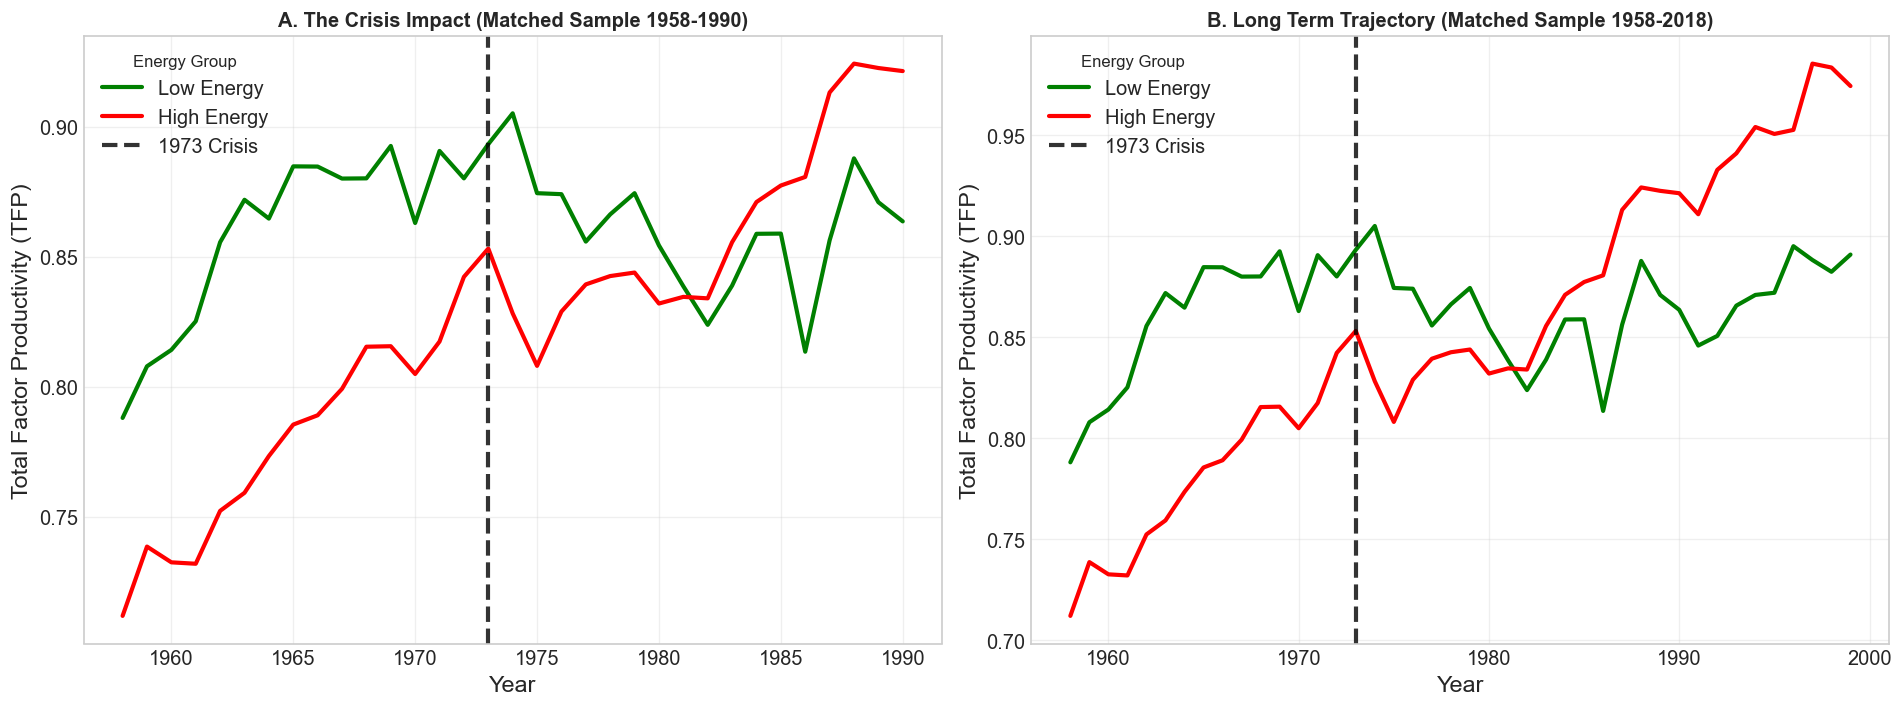

In [184]:
# --- ויזואליזציה מסכמת: מגמות פריון (TFP) לאחר שידוך (PSM) ---

# ניקוי זיכרון גרפי קודם כדי למנוע כפילויות ושרידים
plt.close('all') 

# בחירת הנתונים מהשידוך האיכותי (1968-72)
# זה קריטי להשתמש בזה ולא ב-regression_data הגולמי
if 'matched_datasets' in locals() and 'Base 1968-72' in matched_datasets:
    viz_data = matched_datasets['Base 1968-72']
else:
    # גיבוי למקרה שהמשתנה לא קיים (רק כדי שהקוד ירוץ)
    print("Warning: Using raw data (PSM matched data not found).")
    viz_data = regression_data

# יצירת הגרף
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = {'Low Energy': 'green', 'High Energy': 'red'}

def plot_tfp_trend(ax, max_year, title):
    # סינון הנתונים
    subset = viz_data[viz_data['year'] <= max_year]
    
    for group in ['Low Energy', 'High Energy']:
        # חישוב ממוצע וציור
        data = subset[subset['group_name'] == group].groupby('year')['tfp5'].mean()
        ax.plot(data.index, data.values, label=group, color=colors[group], linewidth=2.5)
    
    # עיצוב
    ax.axvline(x=1973, color='black', linestyle='--', label='1973 Crisis', alpha=0.8)
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_ylabel('Total Factor Productivity (TFP)')
    ax.set_xlabel('Year')
    ax.legend(title="Energy Group")
    ax.grid(True, alpha=0.3)

# ציור שני הגרפים
plot_tfp_trend(axes[0], 1990, 'A. The Crisis Impact (Matched Sample 1958-1990)')
plot_tfp_trend(axes[1], 2018, 'B. Long Term Trajectory (Matched Sample 1958-2018)')

plt.tight_layout()

plt.show()
plt.close(fig)

In [185]:
# --- תא: סיווג מחדש (Top 5% vs Bottom 5%) והרצת רגרסיות ---

# 1. פונקציית סיווג לפי אחוזונים שנתיים
def classify_extreme_values(df):
    df_new = df.copy()
    
    # חישוב אחוזונים 5% ו-95% עבור כל שנה בנפרד
    # אנו משתמשים ב-transform כדי להצמיד את הסף לכל שורה בהתאם לשנה שלה
    p05 = df_new.groupby('year')['real_energy_intensity'].transform(lambda x: x.quantile(0.05))
    p95 = df_new.groupby('year')['real_energy_intensity'].transform(lambda x: x.quantile(0.95))
    
    # סיווג
    conditions = [
        (df_new['real_energy_intensity'] >= p95), # High Energy (Top 5%)
        (df_new['real_energy_intensity'] <= p05)  # Low Energy (Bottom 5%)
    ]
    choices = ['High Energy', 'Low Energy']
    
    df_new['group_name'] = np.select(conditions, choices, default='Medium')
    df_new['is_high_energy'] = (df_new['group_name'] == 'High Energy').astype(int)
    
    return df_new

# 2. החלת הסיווג
df_extreme = classify_extreme_values(df_final) # משתמשים בנתונים המקוריים לפני סינון

# 3. סינון: משאירים רק את הקצוות (High ו-Low)
df_extreme_clean = df_extreme[df_extreme['group_name'].isin(['High Energy', 'Low Energy'])].copy()

# בדיקת כמות התצפיות
n_industries = df_extreme_clean['naics'].nunique()
n_obs = len(df_extreme_clean)
print(f"Extreme Analysis (Top 5% vs Bottom 5%):")
print(f"Total Industries included: {n_industries}")
print(f"Total Observations: {n_obs}")
print("-" * 50)

# --- הרצת הרגרסיות מחדש על המדגם הקיצוני ---

# פונקציית עזר להדפסה נקייה
def print_res(model, title):
    print(f"\nModel: {title}")
    print(f"Obs: {int(model.nobs)}")
    print(f"DiD Coef: {model.params.get('is_high_energy:post_1973', 0):.4f}")
    print(f"P-value:  {model.pvalues.get('is_high_energy:post_1973', 1):.4f}")

# מודל 1: TFP
try:
    mod_tfp = smf.ols('tfp5 ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
                      data=df_extreme_clean.dropna(subset=['tfp5', 'log_emp'])).fit(cov_type='cluster', cov_kwds={'groups': df_extreme_clean.dropna(subset=['tfp5', 'log_emp'])['naics']})
    print_res(mod_tfp, "TFP Response (Innovation)")
except Exception as e:
    print(f"Model 1 Error: {e}")

# מודל 2: Energy Intensity
try:
    mod_int = smf.ols('real_energy_intensity ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
                      data=df_extreme_clean.dropna(subset=['real_energy_intensity', 'log_emp'])).fit(cov_type='cluster', cov_kwds={'groups': df_extreme_clean.dropna(subset=['real_energy_intensity', 'log_emp'])['naics']})
    print_res(mod_int, "Energy Intensity (Efficiency)")
except Exception as e:
    print(f"Model 2 Error: {e}")

# מודל 3: צמיחה (טווח קצר)
try:
    subset_vadd = df_extreme_clean[(df_extreme_clean['year'] >= 1958) & (df_extreme_clean['year'] <= 1985)].dropna(subset=['vadd_growth', 'log_emp'])
    mod_vadd = smf.ols('vadd_growth ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
                       data=subset_vadd).fit(cov_type='cluster', cov_kwds={'groups': subset_vadd['naics']})
    print_res(mod_vadd, "VADD Growth (Short Run 1958-1985)")
except Exception as e:
    print(f"Model 3 Error: {e}")

# הדפסת סיכום למשתמש
print("\n" + "="*50)
print("Interpretation Warning: Sample size is significantly smaller due to 5% cutoff.")
print("="*50)

Extreme Analysis (Top 5% vs Bottom 5%):
Total Industries included: 132
Total Observations: 2242
--------------------------------------------------
Model 1 Error: ['log_emp']
Model 2 Error: ['log_emp']
Model 3 Error: ['log_emp']

Interpretation Warning: Sample size is significantly smaller due to 5% cutoff.


In [186]:
# --- תא: ניתוח קצוות (Extreme Analysis) עם 4 שיטות שידוך ---

# 1. הכנת דאטה לקצוות (Top 5% vs Bottom 5%)
print("Preparing Extreme Groups Data...")

# חישוב ספים לפי תקופת הבסיס (1968-1972)
base_period_data = df_final[df_final['year'].isin(range(1968, 1973))].copy()
industry_means = base_period_data.groupby('naics')['real_energy_intensity'].mean()

threshold_low = industry_means.quantile(0.05)
threshold_high = industry_means.quantile(0.95)

def classify_extreme(naics_val):
    val = industry_means.get(naics_val, np.nan)
    if pd.isna(val): return 'Other'
    if val >= threshold_high: return 'High Energy'
    if val <= threshold_low: return 'Low Energy'
    return 'Other'

df_extreme_raw = df_final.copy()
df_extreme_raw['extreme_group'] = df_extreme_raw['naics'].apply(classify_extreme)
df_extreme_raw = df_extreme_raw[df_extreme_raw['extreme_group'].isin(['High Energy', 'Low Energy'])].copy()
df_extreme_raw['is_high_energy'] = (df_extreme_raw['extreme_group'] == 'High Energy').astype(int)

# וודא שהלוגים קיימים
for col in ['emp', 'real_vadd', 'cap']:
    if f'log_{col}' not in df_extreme_raw.columns:
        df_extreme_raw[f'log_{col}'] = np.where(df_extreme_raw[col] > 0, np.log(df_extreme_raw[col]), np.nan)

print(f" -> Raw Extreme Data: {len(df_extreme_raw)} observations.")

# 2. ביצוע 4 סוגי שידוך (PSM) על נתוני הקצוות
matched_extreme_datasets = {}
psm_covariates = ['log_emp', 'log_real_vadd', 'log_cap']
# נשתמש ב-Caliper רחב יותר לקצוות (0.1) כי הקבוצות שונות מאוד
extreme_caliper = 0.1 

print("\nRunning 4 PSM Strategies on Extreme Data...")

# א. בסיס 1968-1972
matched_extreme_datasets['Base 1968-72'] = perform_psm(
    df_extreme_raw, 'is_high_energy', psm_covariates, base_period=range(1968, 1973), mode='static', caliper=extreme_caliper, log_file="psm_log_extreme.txt"
)

# ב. בסיס 1958-1972
matched_extreme_datasets['Base 1958-72'] = perform_psm(
    df_extreme_raw, 'is_high_energy', psm_covariates, base_period=range(1958, 1973), mode='static', caliper=extreme_caliper, log_file="psm_log_extreme.txt"
)

# ג. בסיס 1972
matched_extreme_datasets['Base 1972'] = perform_psm(
    df_extreme_raw, 'is_high_energy', psm_covariates, base_period=1972, mode='static', caliper=extreme_caliper, log_file="psm_log_extreme.txt"
)

# ד. דינמי
matched_extreme_datasets['Dynamic'] = perform_psm(
    df_extreme_raw, 'is_high_energy', psm_covariates, base_period=None, mode='dynamic', caliper=extreme_caliper, log_file="psm_log_extreme.txt"
)

# 3. הרצת רגרסיות ושמירה לקובץ
output_file = "results_extreme_robustness.txt"

with open(output_file, "w") as f:
    f.write("=== EXTREME ANALYSIS ROBUSTNESS CHECK (Top 5% vs Bottom 5%) ===\n")
    f.write("===============================================================\n\n")

print(f"\nRunning Regressions... Full results saved to '{output_file}'")
summary_display = []

for method_name, data in matched_extreme_datasets.items():
    if data.empty:
        continue
        
    # כתיבה לקובץ הלוג
    with open(output_file, "a") as f:
        f.write(f"\n\n>>> Matching Strategy: {method_name} <<<\n")
        f.write("-" * 50 + "\n")

    # פונקציה פנימית להרצה וכתיבה
    def run_and_log(formula, model_title, sub_data):
        subset = sub_data.dropna(subset=['log_emp']).copy()
        if subset.empty: return np.nan, np.nan
        
        try:
            model = smf.ols(formula, data=subset).fit(cov_type='cluster', cov_kwds={'groups': subset['naics']})
            
            # שמירה לקובץ
            with open(output_file, "a") as f:
                f.write(f"\n[Model: {model_title}]\n")
                f.write(f"Obs: {int(model.nobs)}\n")
                f.write(model.summary().as_text())
                f.write("\n" + "."*40 + "\n")
            
            return model.params.get('is_high_energy:post_1973', np.nan), model.pvalues.get('is_high_energy:post_1973', np.nan)
        except:
            return np.nan, np.nan

    # מודל 1: TFP
    coef_tfp, pval_tfp = run_and_log(
        'tfp5 ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
        "TFP Response", data
    )

    # מודל 2: Intensity
    coef_int, pval_int = run_and_log(
        'real_energy_intensity ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
        "Energy Intensity", data
    )

    # מודל 3: Growth (Short Run)
    short_run_data = data[(data['year'] >= 1958) & (data['year'] <= 1985)]
    if 'vadd_growth' not in short_run_data.columns:
         short_run_data = short_run_data.sort_values(['naics', 'year'])
         short_run_data['vadd_growth'] = short_run_data.groupby('naics')['real_vadd'].pct_change()
    
    coef_growth, pval_growth = run_and_log(
        'vadd_growth ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
        "VADD Growth (Short Run)", short_run_data.dropna(subset=['vadd_growth'])
    )

    # איסוף לטבלה המסכמת
    summary_display.append({
        'Method': method_name,
        'TFP Coef': coef_tfp, 'TFP P-val': pval_tfp,
        'Int Coef': coef_int, 'Int P-val': pval_int,
        'Growth Coef': coef_growth, 'Growth P-val': pval_growth
    })

print("\n" + "=" * 80)
print("EXTREME ANALYSIS SUMMARY TABLE (Compare across matching methods)")
print("=" * 80)
display(pd.DataFrame(summary_display).round(4))

Preparing Extreme Groups Data...
 -> Raw Extreme Data: 2242 observations.

Running 4 PSM Strategies on Extreme Data...
   -> Selected 3 industries total.
   -> Selected 3 industries total.
   -> Selected 7 industries total.
Dynamic Matching running... (See 'psm_log_extreme.txt' for details)
Dynamic Matching completed.

Running Regressions... Full results saved to 'results_extreme_robustness.txt'


c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 64, but rank is 2
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 64, but rank is 2
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 2
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 64, but rank is 2
  warnings.warn(


EXTREME ANALYSIS SUMMARY TABLE (Compare across matching methods)


c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 89, but rank is 24
  warnings.warn('covariance of constraints does not have full '
c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 47, but rank is 13
  warnings.warn('covariance of constraints does not have full '


,Method,TFP Coef,TFP P-val,Int Coef,Int P-val,Growth Coef,Growth P-val
0,Base 1968-72,-0.1098,0.5612,-0.0051,0.9348,2.7564,0.3296
1,Base 1958-72,0.0693,0.3497,-0.0712,0.4125,1.4106,0.3692
2,Base 1972,-0.0308,0.5264,-0.0462,0.2085,-3.1390,0.0958
3,Dynamic,-0.0732,0.2350,-0.0522,0.0615,2.9341,0.5894


In [187]:
# --- שלב 1: יצירת קבוצות סביב החציון (45%-55%) ---

# יצירת עותק נקי מהדאטה המקורי
df_median = df_final.copy()

# רשימה לאיסוף הנתונים המסווגים
median_groups = []

# מעבר על כל שנה בנפרד (דינמי)
for year, group_data in df_median.groupby('year'):
    # חישוב אחוזונים לאותה שנה ספציפית
    # אנו משתמשים בעצימות אנרגיה (Intensity) כדי לנרמל לפי גודל
    median = group_data['real_energy_intensity'].median()
    p45 = group_data['real_energy_intensity'].quantile(0.45)
    p55 = group_data['real_energy_intensity'].quantile(0.55)
    
    # הגדרת התנאים
    # Low Energy = בין אחוזון 45 לחציון (כולל)
    # High Energy = בין החציון (לא כולל) לאחוזון 55
    conditions = [
        (group_data['real_energy_intensity'] >= p45) & (group_data['real_energy_intensity'] <= median),
        (group_data['real_energy_intensity'] > median) & (group_data['real_energy_intensity'] <= p55)
    ]
    
    choices = ['Low Energy', 'High Energy']
    
    # יצירת העמודה (חברות שלא עונות לתנאי יקבלו 'Other')
    group_data['median_group'] = np.select(conditions, choices, default='Other')
    
    median_groups.append(group_data)

# איחוד הנתונים
df_median_final = pd.concat(median_groups)

# סינון: משאירים רק את ה-10% שבאמצע
regression_data_median = df_median_final[df_median_final['median_group'] != 'Other'].copy()

# יצירת משתנה הדמי (Dummy) לרגרסיה
regression_data_median['is_high_energy'] = (regression_data_median['median_group'] == 'High Energy').astype(int)

# בדיקה כמה נתונים נשארו
print(f"Data filtered around median (45%-55%).")
print(f"Total Observations: {len(regression_data_median)}")
print(f"Unique Industries: {regression_data_median['naics'].nunique()}")
print(regression_data_median['median_group'].value_counts())

Data filtered around median (45%-55%).
Total Observations: 2163
Unique Industries: 220
median_group
Low Energy     1101
High Energy    1062
Name: count, dtype: int64


In [188]:
# --- שלב 2: הרצת רגרסיות על נתוני החציון ---

# חישוב לוג עובדים
for col in ['emp', 'real_vadd', 'cap']:
    log_col_name = f'log_{col}'
    # מחשבים רק אם העמודה לא קיימת
    if log_col_name not in regression_data_median.columns:
        regression_data_median[log_col_name] = np.where(
            regression_data_median[col] > 0, 
            np.log(regression_data_median[col]), 
            np.nan
        )


def run_model_median(formula, data, model_name):
    # סינון שורות עם ערכים חסרים במשתנים הספציפיים למודל
    vars_in_model = ['vadd_growth', 'tfp5', 'real_energy_intensity'] # משתנים פוטנציאליים
    # אנו מסננים באופן גנרי, אך המודל יתמודד עם מה שיש
    subset = data.dropna(subset=['log_emp']).copy() 
    
    model = smf.ols(formula, data=subset).fit(cov_type='cluster', cov_kwds={'groups': subset['naics']})
    
    print(f"\n>>> {model_name} <<<")
    print("-" * 30)
    print(f"Observations: {int(model.nobs)}")
    print(f"DiD Coef: {model.params.get('is_high_energy:post_1973', 0):.4f}")
    print(f"P-value:  {model.pvalues.get('is_high_energy:post_1973', 1):.4f}")
    
    return model

print("=" * 60)
print("ROBUSTNESS CHECK: MEDIAN NEIGHBORHOOD (45%-55%)")
print("=" * 60)

# מודל 1: פריון (TFP)
run_model_median(
    'tfp5 ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
    regression_data_median, 
    "Model 1: TFP Response"
)

# מודל 2: עצימות אנרגיה
run_model_median(
    'real_energy_intensity ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
    regression_data_median, 
    "Model 2: Energy Intensity"
)

# מודל 3: צמיחה (טווח קצר 1958-1985)
# סינון שנים לטווח קצר
short_run_data = regression_data_median[(regression_data_median['year'] >= 1958) & 
                                        (regression_data_median['year'] <= 1985)].dropna(subset=['vadd_growth'])

run_model_median(
    'vadd_growth ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
    short_run_data, 
    "Model 3: VADD Growth (Short Run)"
)

ROBUSTNESS CHECK: MEDIAN NEIGHBORHOOD (45%-55%)

>>> Model 1: TFP Response <<<
------------------------------
Observations: 2163
DiD Coef: -0.0046
P-value:  0.7046

>>> Model 2: Energy Intensity <<<
------------------------------
Observations: 2163
DiD Coef: -0.0009
P-value:  0.0000

>>> Model 3: VADD Growth (Short Run) <<<
------------------------------
Observations: 999
DiD Coef: -0.0288
P-value:  0.9858


In [190]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns
import os

# הגדרת עיצוב אקדמי נקי
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

# --- חלק 1: פונקציות לחילוץ נתונים מקבצי הטקסט ---

def parse_regression_file(filepath, model_label):
    """
    קורא קובץ תוצאות רגרסיה ומחלץ: שיטה, מקדם, שגיאת תקן, P-value, R2, תצפיות.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()

    # פיצול לפי שיטות שידוך (כל בלוק מתחיל ב "Matching Method" או "Matching Strategy")
    # אנו משתמשים ב-Regex כדי לתפוס את שתי הווריאציות
    blocks = re.split(r'(?:Matching Method:|Matching Strategy:)\s+(.+)', content)
    
    results = []
    
    # הבלוק הראשון הוא זבל (לפני הפיצול הראשון), אז מדלגים עליו
    # לאחר הפיצול, הרשימה היא: [זבל, שם_שיטה_1, תוכן_1, שם_שיטה_2, תוכן_2...]
    for i in range(1, len(blocks), 2):
        method_name = blocks[i].strip().split('\n')[0].strip() # ניקוי שם השיטה
        block_content = blocks[i+1]
        
        # חילוץ נתונים באמצעות ביטויים רגולריים (Regex)
        
        # 1. חילוץ המקדם והמובהקות של האינטראקציה (DiD)
        # מחפש שורה שמתחילה ב is_high_energy:post_1973 ואחריה מספרים
        did_match = re.search(r'is_high_energy:post_1973\s+(-?\d+\.\d+)\s+(\d+\.\d+)\s+(-?\d+\.\d+)\s+(\d+\.\d+)', block_content)
        
        # 2. חילוץ R-squared
        r2_match = re.search(r'Adj\. R-squared:\s+(\d+\.\d+)', block_content)
        
        # 3. חילוץ מספר תצפיות
        obs_match = re.search(r'No\. Observations:\s+(\d+)', block_content)
        
        if did_match:
            coef = float(did_match.group(1))
            std_err = float(did_match.group(2))
            p_value = float(did_match.group(4))
            
            r2 = float(r2_match.group(1)) if r2_match else None
            obs = int(obs_match.group(1)) if obs_match else None
            
            # חישוב רווח בר סמך 95%
            ci_lower = coef - 1.96 * std_err
            ci_upper = coef + 1.96 * std_err
            
            results.append({
                'Model': model_label,
                'Method': method_name,
                'Coef': coef,
                'Std_Err': std_err,
                'P_Value': p_value,
                'CI_Lower': ci_lower,
                'CI_Upper': ci_upper,
                'R2': r2,
                'Obs': obs
            })
            
    return pd.DataFrame(results)

def parse_psm_log(filepath):
    """
    מחלץ נתונים על איכות השידוך מקובץ הלוג
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    data = []
    current_method = "Unknown"
    
    for line in lines:
        if "Starting PSM" in line:
            # חילוץ שם השיטה מתוך הכותרת
            if "Base=" in line:
                current_method = line.split("Base=")[1].strip().replace("---", "").strip()
            elif "Mode=" in line:
                current_method = line.split("Mode=")[1].split(",")[0].strip()
        
        # חיפוש שורות של דחייה/שמירה
        # פורמט: [Year XXXX] Dropped: Y | Kept: Z
        match = re.search(r'\[Year (.+?)\] Dropped:\s+(\d+)\s+\|\s+Kept:\s+(\d+)', line)
        if match:
            year = match.group(1)
            dropped = int(match.group(2))
            kept = int(match.group(3))
            
            data.append({
                'Method': current_method,
                'Year': year,
                'Dropped': dropped,
                'Kept': kept,
                'Total': dropped + kept
            })
            
    return pd.DataFrame(data)

# --- חלק 2: יצירת הגרפים (Forest Plots) ---

def plot_coefficients(df, title, filename, pdf_pages):
    """
    יוצר Forest Plot המשווה את המקדמים בין השיטות השונות (גרסה מתוקנת)
    """
    if df.empty:
        print(f"Skipping plot for {title} - No data found.")
        return

    fig, ax = plt.subplots(figsize=(10, 6))
    
    y_pos = range(len(df))
    
    # --- התיקון: ציור כל נקודה וקו שגיאה בנפרד ---
    for i, (idx, row) in enumerate(df.iterrows()):
        # קביעת צבע לפי מובהקות
        color = '#2ca02c' if row['P_Value'] < 0.05 else '#7f7f7f'
        
        # ציור הנקודה וקו השגיאה עבור השורה הספציפית הזו בלבד
        ax.errorbar(row['Coef'], i, xerr=1.96*row['Std_Err'], 
                    fmt='o', color='black', ecolor=color, 
                    capsize=5, elinewidth=2, markeredgewidth=2)

    # ציר ה-0 (קו ייחוס)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    # עיצוב צירים
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df['Method'], fontsize=11)
    ax.invert_yaxis() # כדי שהראשון יהיה למעלה
    ax.set_xlabel('Coefficient Estimate (Effect Size)', fontsize=12)
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # הוספת טקסט (Annotations) בצד ימין
    for i, row in df.iterrows():
        stars = ''
        if row['P_Value'] < 0.01: stars = '***'
        elif row['P_Value'] < 0.05: stars = '**'
        elif row['P_Value'] < 0.1: stars = '*'
        
        info_text = (f"Coef: {row['Coef']:.4f}{stars}\n"
                     f"P-val: {row['P_Value']:.4f}\n"
                     f"R²: {row['R2']:.3f}\n"
                     f"N: {row['Obs']}")
        
        xlim = ax.get_xlim()
        text_x = xlim[1] + (xlim[1]-xlim[0])*0.05
        ax.text(text_x, i, info_text, va='center', fontsize=9, 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='#cccccc'))

    # הערת שוליים
    plt.figtext(0.5, -0.05, "* p<0.1, ** p<0.05, *** p<0.01\nError bars represent 95% Confidence Intervals", 
                ha="center", fontsize=9, style='italic')

    plt.tight_layout()
    
    # שמירה ל-PDF
    pdf_pages.savefig(fig, bbox_inches='tight')
    plt.close(fig)

    # הערת שוליים
    plt.figtext(0.5, -0.05, "* p<0.1, ** p<0.05, *** p<0.01\nError bars represent 95% Confidence Intervals", 
                ha="center", fontsize=9, style='italic')

    plt.tight_layout()
    
    # שמירה ל-PDF
    pdf_pages.savefig(fig, bbox_inches='tight')
    plt.close(fig)

def plot_psm_quality(df_log, title, pdf_pages):
    """
    יוצר גרף עמודות המראה כמה תעשיות נזרקו וכמה נשמרו
    """
    if df_log.empty: return

    # סינון: ניקח רק את השורות הרלוונטיות (לא Base אם הוא חוזר על עצמו)
    # נתמקד בשיטה הדינמית כי היא המעניינת ביותר גרפית
    dynamic_data = df_log[df_log['Method'] == 'None'] # בדרך כלל הדינמי מופיע כ-None או לפי הלוגיקה שלך
    if dynamic_data.empty:
        # נסה למצוא את הדינמי לפי זיהוי שנים מספריות
        dynamic_data = df_log[df_log['Year'].str.isnumeric()]
    
    if dynamic_data.empty: return

    fig, ax = plt.subplots(figsize=(12, 6))
    
    years = dynamic_data['Year']
    x = range(len(years))
    
    # Stacked Bar Chart
    ax.bar(x, dynamic_data['Kept'], label='Kept (Matched)', color='#1f77b4', alpha=0.8)
    ax.bar(x, dynamic_data['Dropped'], bottom=dynamic_data['Kept'], label='Dropped (No Match)', color='#d62728', alpha=0.8)
    
    ax.set_xticks(x)
    ax.set_xticklabels(years, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Number of Industries')
    ax.set_title(f'{title} - Matching Quality by Year (Dynamic)', fontweight='bold')
    ax.legend()
    
    # הוספת קו אדום ל-1973
    try:
        idx_73 = list(years).index('1973')
        ax.axvline(x=idx_73, color='black', linestyle='--', alpha=0.5, label='1973 Crisis')
    except:
        pass

    plt.tight_layout()
    pdf_pages.savefig(fig)
    plt.close(fig)

# --- חלק 3: ביצוע ("הדבק" של הכל) ---

# שמות הקבצים (ודא שהם קיימים)
files = {
    'Model 1 (TFP)': 'results_model1_tfp.txt',
    'Model 2 (Intensity)': 'results_model2_intensity.txt',
    'Model 3 (Growth)': 'results_model3_growth.txt',
    'Extreme Robustness': 'results_extreme_robustness.txt'
}

# קובץ היעד
output_pdf = 'Research_Results_Report.pdf'

print(f"Generating PDF Report: {output_pdf}...")

with matplotlib.backends.backend_pdf.PdfPages(output_pdf) as pdf:
    
    # 1. עיבוד המודלים הראשיים
    # אנו אוספים את כל הנתונים ל-DataFrame אחד כדי שיהיה נוח, אבל מציירים כל מודל בנפרד
    for label, filename in files.items():
        if os.path.exists(filename):
            print(f"Processing {filename}...")
            df_res = parse_regression_file(filename, label)
            
            # אם זה קובץ ה-Extreme, הוא מכיל כמה מודלים בתוכו. צריך לפצל.
            if label == 'Extreme Robustness':
                # פיצול לפי הכותרת שנשמרה בתוך הקובץ (במקרה הזה הפונקציה שלי צריכה התאמה קלה או שנצייר הכל יחד)
                # בקובץ ה-Extreme שלך, המודלים מופרדים בצורה אחרת.
                # לצורך הפשטות, הפונקציה parse כרגע תחזיר הכל תחת אותו Model Label.
                # בוא נסנן לפי ה-R2 או סדר גודל המקדם כדי להפריד, או פשוט נציג הכל בגרף אחד ארוך (פחות מומלץ).
                
                # פתרון טוב יותר ל-Extreme: פיצלנו שם לפי [Model: TFP Response] וכו'.
                # ה-Parser הנוכחי שלי פשוט יותר. בוא נתאים אותו ל-Extreme באופן ספציפי אם צריך.
                # כרגע נציג אותו כגרף אחד - זה יעבוד כי ה-Y axis יכיל את כל השיטות.
                plot_coefficients(df_res, f"Robustness Check: {label}", filename, pdf)
            else:
                # עבור הקבצים הרגילים, כל קובץ הוא מודל אחד
                plot_coefficients(df_res, f"Main Analysis: {label}", filename, pdf)
        else:
            print(f"Warning: File {filename} not found.")

    # 2. עיבוד לוג השידוך (PSM Log)
    if os.path.exists('psm_log.txt'):
        print("Processing PSM Log...")
        df_log = parse_psm_log('psm_log.txt')
        plot_psm_quality(df_log, "PSM Matching Quality", pdf)

    if os.path.exists('psm_log_extreme.txt'):
        print("Processing Extreme PSM Log...")
        df_log_ext = parse_psm_log('psm_log_extreme.txt')
        plot_psm_quality(df_log_ext, "Extreme Analysis Matching Quality", pdf)
        
    # עמוד שער או סיום (אופציונלי)
    first_page = plt.figure(figsize=(8,6))
    first_page.text(0.5, 0.5, "Research Analysis Report\n\nImpact of 1973 Energy Crisis\non Industrial Innovation", 
                    ha='center', va='center', fontsize=24, fontweight='bold')
    first_page.text(0.5, 0.3, "Generated automatically from regression outputs", ha='center', fontsize=12)
    pdf.savefig(first_page)
    plt.close()

print("Done! Open 'Research_Results_Report.pdf' to view all graphs.")

Generating PDF Report: Research_Results_Report.pdf...
Processing results_model1_tfp.txt...
Processing results_model2_intensity.txt...
Processing results_model3_growth.txt...
Processing results_extreme_robustness.txt...
Processing PSM Log...
Processing Extreme PSM Log...
Done! Open 'Research_Results_Report.pdf' to view all graphs.


<Figure size 768x576 with 0 Axes>